# Data Science Case Study
Analysis by Daniel Shin
____

## Table of Contents

1. [Pulling data](#pull)
2. [Cleaning and Exploration](#eda)
  1. [User data](#user)
  2. [App data](#app)
  3. [Loan data](#loan)
3. [Descriptive Analysis](#desc)
4. [Preprocessing and Feature Extraction](#feat)
5. [Predictive Modeling](#modeling)
  1. [Loan purchase prediction](#loan_model)
    * [Cross validation](#loan_cv)
    * [Predictors](#loan_preds)
    * [Sample Tree](#loan_tree)
  2. [Loan submission prediction](#submit)
    * [Cross validation](#submit_cv)
    * [Predictors](#submit_preds)
    * [Sample Tree](#submit_tree)


In [1]:
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline
sns.set()

/Users/dshin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
db_info = {'user_name': "abc",
           'password': "xyz",
           'host_name': "abcxyz.us-east-1.rds.amazonaws.com",
           'port_num': "5432",
           'db_name': "mydb"
          }

In [3]:
conn = psycopg2.connect(dbname=db_info['db_name'],
                user=db_info['user_name'],
                password=db_info['password'],
                host=db_info['host_name'],
                port=db_info['port_num'])

<a id='pull'></a>
## Pulling data

In [4]:
# Get table names

sql = "SELECT table_name FROM information_schema.tables WHERE table_schema = 'staging'"
tables = pd.read_sql_query(sql, conn)
print(tables)

  table_name
0       user
1        app
2       loan


In [5]:
# Find number of rows per table

tables = [x[0] for x in tables.values]

for table in tables:
    sql = "SELECT COUNT(1) FROM staging.{}".format(table)
    temp = pd.read_sql_query(sql, conn)
    print(table, '-', temp.values[0][0])

user - 3883
app - 4627
loan - 2384


In [6]:
# Get tables

sql = 'SELECT * FROM staging.'

user = pd.read_sql_query(sql + 'user', conn)
app = pd.read_sql_query(sql + 'app', conn)
loan = pd.read_sql_query(sql + 'loan', conn)

<a id='eda'></a>
## Cleaning and Exploratory Data Analysis

<a id='user'></a>
### User data

There was approximately 6 months of signup data available. The number of signups grew over the course of the dataset with periodic trends every 1-2 months. The most signups occurred in the month of August.

In [7]:
user.head()

,first_visit_at,account_created_at,account_id_mapping,started
0,None,2017-05-30 05:08:43.418219,2875,1
1,None,2017-06-08 05:40:50.753784,3778,1
2,None,2017-06-26 13:38:54.578531,3163,1
3,2017-03-26,2017-04-01 20:01:29.996902,528,1
4,None,2017-04-01 21:33:09.478677,492,1


In [8]:
print('First account created:', user['account_created_at'].min())
print('Last account created:', user['account_created_at'].max())

First account created: 2017-04-01 20:01:29.996902
Last account created: 2017-09-30 23:48:10.131010


Text(0.5,0,'Date account created')

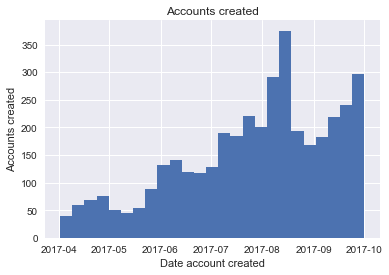

In [10]:
user['account_created_at'] = pd.to_datetime(user['account_created_at'])

user['account_created_at'].hist(bins=25)
plt.title('Accounts created')
plt.ylabel('Accounts created')
plt.xlabel('Date account created')

In [11]:
# Clean up user table

user.drop('started', axis=1, inplace=True)
user.set_index('account_id_mapping', inplace=True)
user['first_visit_at'] = pd.to_datetime(user['first_visit_at'])
# user['time_to_create_account'] = user['account_created_at'] - user['first_visit_at']

user.head()

,first_visit_at,account_created_at
account_id_mapping,,
2875,NaT,2017-05-30 05:08:43.418219
3778,NaT,2017-06-08 05:40:50.753784
3163,NaT,2017-06-26 13:38:54.578531
528,2017-03-26,2017-04-01 20:01:29.996902
492,NaT,2017-04-01 21:33:09.478677


In [12]:
user['account_created_date'] = user['account_created_at'].dt.date
user['account_created_month'] = user['account_created_at'].dt.month
user['account_created_dayofweek'] = user['account_created_at'].dt.dayofweek

<a id='app'></a>
### App data

Out of all applications in the data, 8.7% of them were denied. 93.7% of applications involved were for a primary residence, 5.1% an investment, and 1.2% a second home. A significant number of records were missing data and were not mapped to a loan. The median values of quantitative columns were: 
* Loan to value ratio - 0.69
* Loan amount - \$283,000
* Total monthly income - \$108,330
* Combined assets - \$82,500
* Beta credit score - 5

In [13]:
app.head()

,denied,ltv,loan_amount,coborrower_contact_created,property_type,preapproval_total_monthly_income,preapproval_combined_assets,account_id_mapping,preapproval_id_mapping,loan_file_id_mapping,beta_credit_score_proxy,borrower_state_mapped
0,1,0.00000,0.0,None,PrimaryResidence,16666.0,NaN,528,3400,267.0,5,NV
1,0,0.86470,363164.0,None,PrimaryResidence,14166.0,NaN,492,2117,509.0,5,RI
2,0,0.43814,416233.0,None,PrimaryResidence,14582.0,NaN,3099,313,19.0,3,NV
3,1,NaN,NaN,None,PrimaryResidence,10416.0,NaN,74,3000,NaN,3,OK
4,0,NaN,NaN,None,PrimaryResidence,NaN,NaN,3090,221,NaN,6,AL


In [15]:
app['account_id_mapping'].nunique()

3870

In [16]:
app.isnull().sum() # Get null values

denied                                 0
ltv                                 2203
loan_amount                         2069
coborrower_contact_created          3722
property_type                          0
preapproval_total_monthly_income    1919
preapproval_combined_assets         2315
account_id_mapping                     0
preapproval_id_mapping                 0
loan_file_id_mapping                2295
beta_credit_score_proxy                0
borrower_state_mapped                  0
dtype: int64

In [17]:
app[['denied', 'ltv', 'loan_amount', 'preapproval_total_monthly_income',
     'preapproval_combined_assets', 'beta_credit_score_proxy']].describe()

,denied,ltv,loan_amount,preapproval_total_monthly_income,preapproval_combined_assets,beta_credit_score_proxy
count,4627.000000,2424.000000,2.558000e+03,2.708000e+03,2.312000e+03,4627.000000
mean,0.086665,2.012848,3.318275e+05,1.720009e+04,2.250703e+05,4.724443
std,0.281374,30.798522,8.533999e+05,1.216081e+05,4.745392e+05,1.461545
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
25%,0.000000,0.516594,1.785802e+05,7.083000e+03,2.400000e+04,4.000000
50%,0.000000,0.693079,2.832065e+05,1.083300e+04,8.250000e+04,5.000000
75%,0.000000,0.786027,4.089645e+05,1.641600e+04,2.390000e+05,6.000000
max,1.000000,849.379000,4.210451e+07,5.929000e+06,1.000000e+07,6.000000


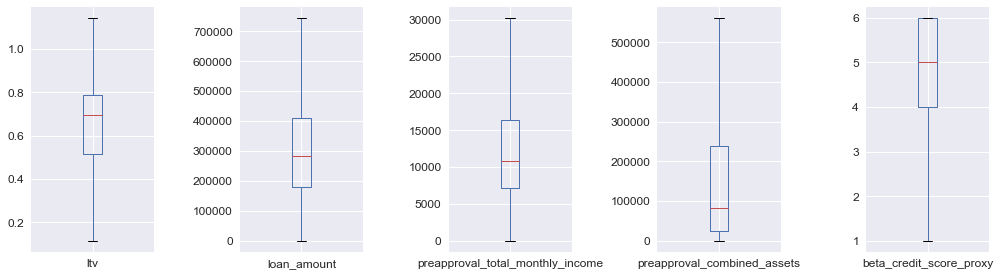

In [18]:
# Boxplots of quantitative data, w/o outliers

app[['ltv', 'loan_amount', 'preapproval_total_monthly_income',
    'preapproval_combined_assets', 'beta_credit_score_proxy']].plot.box(
    showfliers=False, subplots=True, figsize=(14,4), fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
app['property_type'].value_counts() # Get property types

PrimaryResidence    4337
Investment           234
SecondHome            56
Name: property_type, dtype: int64

In [20]:
app['denied'].value_counts() # Get number of applications denied

0    4226
1     401
Name: denied, dtype: int64

(-1.1033312934968438,
 1.1001586330236592,
 -1.1028538704342354,
 1.1196304087158941)

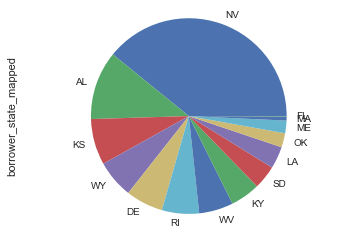

In [21]:
app['borrower_state_mapped'].value_counts().plot.pie()
plt.axis('equal')

In [22]:
# Clean app data

app['ltv'] = app['ltv'].apply(lambda x: min(1.0, x) if pd.notnull(x) else np.nan) # Remove outliers in LTV
app['coborrower_contact_created'] = app['coborrower_contact_created'].fillna(0)*1
app['completed_loan_docs'] = app['loan_file_id_mapping'].notnull() * 1
app.set_index(['loan_file_id_mapping'], drop=True, inplace=True)
app.head()

,denied,ltv,loan_amount,coborrower_contact_created,property_type,preapproval_total_monthly_income,preapproval_combined_assets,account_id_mapping,preapproval_id_mapping,beta_credit_score_proxy,borrower_state_mapped,completed_loan_docs
loan_file_id_mapping,,,,,,,,,,,,
267.0,1,0.00000,0.0,0,PrimaryResidence,16666.0,NaN,528,3400,5,NV,1
509.0,0,0.86470,363164.0,0,PrimaryResidence,14166.0,NaN,492,2117,5,RI,1
19.0,0,0.43814,416233.0,0,PrimaryResidence,14582.0,NaN,3099,313,3,NV,1
NaN,1,NaN,NaN,0,PrimaryResidence,10416.0,NaN,74,3000,3,OK,0
NaN,0,NaN,NaN,0,PrimaryResidence,NaN,NaN,3090,221,6,AL,0


<a id='loan'></a>
### Loan data

Approximately 25% of available loans (documents completed) were purchased by a borrower. The median values of quantiative columns were:
* Number of years employed at current job - 5-6 years
* Self reported monthly income - \$114,655
* Total verified assets - \$25,176
* Loan total monthly income - \$115,160
* Loan total monthly debt - \$3,196
* Appraised value of home - \$475,000
* Annual property tax - \$4,613
* Age bin - 5

In [23]:
loan.head()

,refinance_type,is_self_employed,employment__current_extra_months_on_job,employment__current_full_years_on_job,marital_status,income__new_self_reported_monthly_amount,assets__verified_total,loan__total_monthly_income,loan__total_monthly_debt,appraised_value,in_competitive_region,property_tax__yearly_amount,completed,purchased,account_id_mapping,loan_file_id_mapping,age_bin,borrower_satisfaction
0,RateTermRefi,False,5.0,3.0,Separated,9428.0,NaN,8443.685523,1097.756730,NaN,True,NaN,1,0,2641,721,5,None
1,RateTermRefi,False,0.0,16.0,Married,13416.0,NaN,13416.000000,4118.586020,NaN,False,2726.57,1,0,450,1942,5,great
2,RateTermRefi,False,NaN,NaN,Married,3160.0,NaN,3160.000000,339.875000,NaN,None,NaN,1,0,313,772,6,None
3,CashOutRefi,False,8.0,16.0,Married,30833.0,NaN,30833.000000,4062.904137,NaN,None,6995.89,1,1,1850,421,7,None
4,CashOutRefi,True,NaN,NaN,Married,11083.0,NaN,11083.000000,2654.631952,NaN,None,NaN,1,0,875,990,4,None


In [24]:
loan.isnull().sum() # Get null values

refinance_type                                 0
is_self_employed                              27
employment__current_extra_months_on_job     1457
employment__current_full_years_on_job       1508
marital_status                               704
income__new_self_reported_monthly_amount      20
assets__verified_total                      2095
loan__total_monthly_income                     0
loan__total_monthly_debt                       0
appraised_value                             1937
in_competitive_region                       1697
property_tax__yearly_amount                 1326
completed                                      0
purchased                                      0
account_id_mapping                             0
loan_file_id_mapping                           0
age_bin                                        0
borrower_satisfaction                       2047
dtype: int64

In [25]:
loan.describe()

,employment__current_extra_months_on_job,employment__current_full_years_on_job,income__new_self_reported_monthly_amount,assets__verified_total,loan__total_monthly_income,loan__total_monthly_debt,appraised_value,property_tax__yearly_amount,completed,purchased,account_id_mapping,loan_file_id_mapping,age_bin
count,927.000000,876.000000,2.364000e+03,2.890000e+02,2.384000e+03,2384.000000,4.470000e+02,1058.000000,2384.0,2384.000000,2384.000000,2384.000000,2384.000000
mean,5.732470,7.624429,1.863451e+04,1.047738e+05,1.713215e+04,3914.837906,5.940207e+05,5316.001616,1.0,0.249161,1961.199245,1192.500000,5.359480
std,3.349938,7.568011,1.306975e+05,2.679959e+05,5.009275e+04,9684.178071,4.232200e+05,3751.165118,0.0,0.432618,1131.872011,688.345843,1.907967
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+02,0.000000,1.0,0.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,7.553000e+03,7.330000e+03,7.500000e+03,2184.925955,3.480000e+05,2789.835000,1.0,0.000000,962.250000,596.750000,4.000000
50%,5.000000,5.000000,1.146550e+04,2.517600e+04,1.151599e+04,3195.827242,4.750000e+05,4613.090000,1.0,0.000000,1997.500000,1192.500000,5.000000
75%,9.000000,10.000000,1.696775e+04,8.887700e+04,1.707175e+04,4559.657281,7.225000e+05,6808.152500,1.0,0.000000,2930.750000,1788.250000,7.000000
max,11.000000,45.000000,5.929000e+06,2.495000e+06,1.806441e+06,459375.000000,3.600000e+06,34021.000000,1.0,1.000000,3883.000000,2384.000000,8.000000


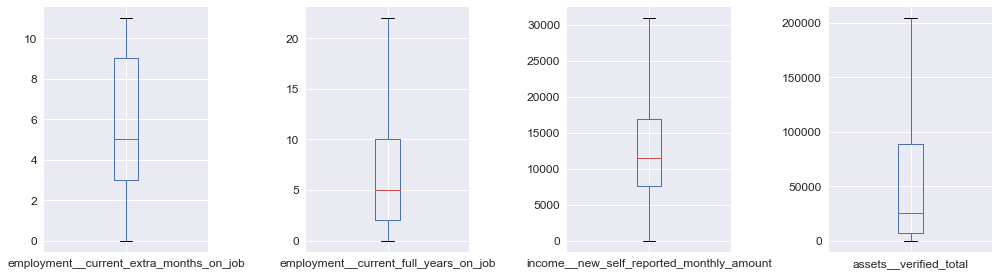

In [26]:
# Boxplots of quantitative data, w/o outliers

loan[['employment__current_extra_months_on_job', 'employment__current_full_years_on_job',
      'income__new_self_reported_monthly_amount', 'assets__verified_total']].plot.box(
    showfliers=False, subplots=True, figsize=(14,4), fontsize=12)
plt.tight_layout()
plt.show()

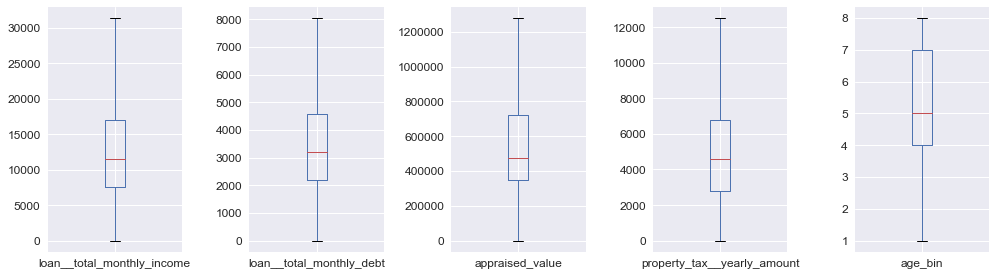

In [27]:
# Boxplots of quantitative data, w/o outliers

loan[['loan__total_monthly_income', 'loan__total_monthly_debt', 'appraised_value',
      'property_tax__yearly_amount', 'age_bin']].plot.box(showfliers=False, subplots=True, figsize=(14,4), fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# Clean up loan table

loan['employment_months_on_job'] = loan['employment__current_full_years_on_job'] * 12 + loan['employment__current_extra_months_on_job']
loan.drop(['completed', 'employment__current_full_years_on_job', 'employment__current_extra_months_on_job'], axis=1, inplace=True)  # drop column, all 1's
loan.set_index(['loan_file_id_mapping', 'account_id_mapping'], inplace=True)

loan.head()

,,refinance_type,is_self_employed,marital_status,income__new_self_reported_monthly_amount,assets__verified_total,loan__total_monthly_income,loan__total_monthly_debt,appraised_value,in_competitive_region,property_tax__yearly_amount,purchased,age_bin,borrower_satisfaction,employment_months_on_job
loan_file_id_mapping,account_id_mapping,,,,,,,,,,,,,,
721,2641,RateTermRefi,False,Separated,9428.0,NaN,8443.685523,1097.756730,NaN,True,NaN,0,5,None,41.0
1942,450,RateTermRefi,False,Married,13416.0,NaN,13416.000000,4118.586020,NaN,False,2726.57,0,5,great,192.0
772,313,RateTermRefi,False,Married,3160.0,NaN,3160.000000,339.875000,NaN,None,NaN,0,6,None,NaN
421,1850,CashOutRefi,False,Married,30833.0,NaN,30833.000000,4062.904137,NaN,None,6995.89,1,7,None,200.0
990,875,CashOutRefi,True,Married,11083.0,NaN,11083.000000,2654.631952,NaN,None,NaN,0,4,None,NaN


<a id=desc></a>
### Descriptive Analysis and Purchase Funnel Analysis

Nearly all users (99.7%) who signed up also completed an application, suggesting that submitting an application is a requirement for signing up or only users who completed an application were included in the dataset. Most users completed 1 application, but ~28% of users completed 2 or more. All users in the 'app' and 'loan' tables were accounted for in the 'user' table. 

60% of users who signed up also submitted their loan documents, which is pretty high. However, of those who submitted their documents, only 25% went on to purchase a loan. This is a potential source of improvement.

In [29]:
unique_users = set(user.index)
unique_apps = set(app.index)
unique_users_apps = set(app['account_id_mapping'].unique())
unique_loan_apps = set(app.index.unique())
unique_loans = set(loan.index.labels[0])
unique_users_loans = set(list(loan.index.labels[1]))
unique_users_purchased = set(loan[loan['purchased'] == True].index.labels[1])

In [30]:
user_submitted_app = len(unique_users_apps.intersection(unique_users))
user_submitted_loan_doc = len(unique_loans.intersection(unique_loan_apps))
user_purchased_loan = len(unique_users_purchased)

print('{: <20} {: <5} {: >5}%'.format('Signed up', len(unique_users), 100.0))
print('{: <20} {: <5} {: >5}%'.format('Submit app', user_submitted_app, round(user_submitted_app/len(unique_users)* 100, 1)))
print('{: <20} {: <5} {: >5}%'.format('Submit loan docs', user_submitted_loan_doc, round(user_submitted_loan_doc/len(unique_users) * 100, 1)))
print('{: <20} {: <5} {: >5}%'.format('Purchase loan', user_purchased_loan, round(user_purchased_loan/len(unique_users) * 100, 1)))

Signed up            3883  100.0%
Submit app           3870   99.7%
Submit loan docs     2331   60.0%
Purchase loan        562    14.5%


Percentages are based on the number of unique users and not on the number of unique applications.

In [31]:
# Number of applications completed by each user

app.groupby('account_id_mapping').size().value_counts()

1     3343
2      380
3       99
4       30
5       12
9        2
6        2
7        1
10       1
dtype: int64

In [32]:
app.groupby('account_id_mapping').size().value_counts()/app['account_id_mapping'].nunique()

1     0.863824
2     0.098191
3     0.025581
4     0.007752
5     0.003101
9     0.000517
6     0.000517
7     0.000258
10    0.000258
dtype: float64

#### Univariate Anaylsis

In [33]:
loan.groupby('age_bin')['purchased'].mean()

age_bin
1    0.000000
2    0.294118
3    0.277937
4    0.286374
5    0.250000
6    0.242331
7    0.247863
8    0.196190
Name: purchased, dtype: float64

In [34]:
loan.groupby('refinance_type')['purchased'].mean()

refinance_type
CashOutRefi     0.253012
RateTermRefi    0.246398
Name: purchased, dtype: float64

In [35]:
loan.groupby('in_competitive_region')['purchased'].mean()

in_competitive_region
False    0.225806
True     0.256545
Name: purchased, dtype: float64

<a id='feat'></a>
### Preprocessing and feature extraction

* Create dummy variables for categorical inputs
* Fill in missing values with column averages

In [36]:
app_predictors = ['denied', 'ltv', 'loan_amount', 'coborrower_contact_created', 'property_type', 'preapproval_total_monthly_income', 'preapproval_combined_assets', 'beta_credit_score_proxy', 'borrower_state_mapped']

In [37]:
app.head()

,denied,ltv,loan_amount,coborrower_contact_created,property_type,preapproval_total_monthly_income,preapproval_combined_assets,account_id_mapping,preapproval_id_mapping,beta_credit_score_proxy,borrower_state_mapped,completed_loan_docs
loan_file_id_mapping,,,,,,,,,,,,
267.0,1,0.00000,0.0,0,PrimaryResidence,16666.0,NaN,528,3400,5,NV,1
509.0,0,0.86470,363164.0,0,PrimaryResidence,14166.0,NaN,492,2117,5,RI,1
19.0,0,0.43814,416233.0,0,PrimaryResidence,14582.0,NaN,3099,313,3,NV,1
NaN,1,NaN,NaN,0,PrimaryResidence,10416.0,NaN,74,3000,3,OK,0
NaN,0,NaN,NaN,0,PrimaryResidence,NaN,NaN,3090,221,6,AL,0


In [38]:
loan_merged = pd.merge(loan, user[['account_created_month']], left_index=True, right_index=True, how='left')
loan_merged = pd.merge(loan_merged, app[app.index.notnull()][app_predictors], left_index=True, right_index=True, how='left')
user_app = pd.merge(app, user[['account_created_month']], left_on='account_id_mapping', right_index=True, how='left')

In [39]:
app.head()

,denied,ltv,loan_amount,coborrower_contact_created,property_type,preapproval_total_monthly_income,preapproval_combined_assets,account_id_mapping,preapproval_id_mapping,beta_credit_score_proxy,borrower_state_mapped,completed_loan_docs
loan_file_id_mapping,,,,,,,,,,,,
267.0,1,0.00000,0.0,0,PrimaryResidence,16666.0,NaN,528,3400,5,NV,1
509.0,0,0.86470,363164.0,0,PrimaryResidence,14166.0,NaN,492,2117,5,RI,1
19.0,0,0.43814,416233.0,0,PrimaryResidence,14582.0,NaN,3099,313,3,NV,1
NaN,1,NaN,NaN,0,PrimaryResidence,10416.0,NaN,74,3000,3,OK,0
NaN,0,NaN,NaN,0,PrimaryResidence,NaN,NaN,3090,221,6,AL,0


In [40]:
# Feature extraction

loan_df = loan_merged.copy()
loan_df['account_created_month'].astype(str, inplace=True)
loan_df['is_cash_out'] = loan['refinance_type'].apply(lambda x: 1 if x == 'CashOutRefi' else 0)
loan_df['is_self_employed'] = loan['is_self_employed'] * 1
loan_df['in_competitive_region'] = loan['in_competitive_region'] * 1
loan_df['account_created_month'] = loan_df['account_created_month'].apply(lambda x: 'm' + str(x))
loan_df.drop('refinance_type', axis=1, inplace=True)
loan_df.drop('borrower_satisfaction', axis=1, inplace=True)   # Too many missing values

In [41]:
# # Create separate column to track if a field's value is missing

# loan_df['employment_months_is_null'] = pd.isnull(loan_df['employment__current_extra_months_on_job']) * 1
# loan_df['employment_years_is_null'] = pd.isnull(loan_df['employment__current_full_years_on_job']) * 1
# loan_df['marital_status_is_null'] = pd.isnull(loan_df['marital_status']) * 1
# loan_df['assets_is_null'] = pd.isnull(loan_df['assets__verified_total']) * 1
# loan_df['appraised_value_is_null'] = pd.isnull(loan_df['appraised_value']) * 1
# loan_df['competitive_region_is_null'] = pd.isnull(loan_df['in_competitive_region']) * 1
# loan_df['property_tax_is_null'] = pd.isnull(loan_df['property_tax__yearly_amount']) * 1

In [42]:
# Impute missing values for columns with few missing values

loan_df['is_self_employed'].fillna(0, inplace=True)
loan_df['income__new_self_reported_monthly_amount'].fillna(loan_df['income__new_self_reported_monthly_amount'].mean(), inplace=True)

In [43]:
# Get dummy columns for marital status
categorical = ['marital_status' ,'account_created_month', 'property_type', 'borrower_state_mapped']

loan_df = pd.concat([loan_df, pd.get_dummies(loan_df[categorical])], axis=1)
loan_df.drop(['marital_status', 'account_created_month', 'borrower_state_mapped', 'property_type'], axis=1, inplace=True)

In [44]:
loan_df.fillna(loan_df.mean(), inplace=True)

<a id='modeling'></a>
### Predictive modeling

<a id='loan_model'></a>
#### Loan purchase prediction

A model was able to reliably predict whether a completed loan application resulted in a purchase (accuracy: ~95-96%). Some important features in order of importance (using variables importances from Random Forest model) are:
* The appraised value (higher appraised value -> purchased loan; the appraised value for purchased loans was approximately <b>164% higher</b> than appraised value for unpurchased loans; \$594,848 vs \$225,000)
* Amount of verified assets (those who purchased the loan had <b>457% more assets</b> than those who submitted loan documents but didn't purchase the loan; \$107,208 vs \$19,250)
* Annual property tax
* Self reported income (those who purchased loans had a <b>67% higher monthly income</b> than those who did not)

In general, it appears that users who are high earners + more wealthier with a higher appraisal value of their home are more likely to purchase the loan. This makes sense, but the differences between the groups are quite substantial.

In [45]:
# Univariate analysis

include_variables = []

for var in loan_df.columns:
    if var != 'purchased':
        temp = loan_df[[var, 'purchased']]
        temp = temp.dropna()
        mod = chi2(temp[[var]], temp['purchased'])
        
        print('var={: <45} f={: <10} p={: <5}'.format(var, round(mod[0][0],2), round(mod[1][0],2)))
        
        if mod[1][0] < 0.05:
            include_variables.append(var)
# X_new = kbest_mod.fit_transform(loan_df.drop('purchased', axis=1), loan_df['purchased'])

var=is_self_employed                              f=1.11       p=0.29 
var=income__new_self_reported_monthly_amount      f=2719256.22 p=0.0  
var=assets__verified_total                        f=10017.7    p=0.0  
var=loan__total_monthly_income                    f=349.35     p=0.0  
var=loan__total_monthly_debt                      f=774.58     p=0.0  
var=appraised_value                               f=514.0      p=0.0  
var=in_competitive_region                         f=0.14       p=0.7  
var=property_tax__yearly_amount                   f=3373.44    p=0.0  
var=age_bin                                       f=7.35       p=0.01 
var=employment_months_on_job                      f=0.04       p=0.84 
var=denied                                        f=26.11      p=0.0  
var=ltv                                           f=0.03       p=0.87 
var=loan_amount                                   f=10823346.96 p=0.0  
var=coborrower_contact_created                    f=10.86      p=0.0  
var=p

In [46]:
X = loan_df[include_variables]

rf = RandomForestClassifier(n_estimators=250, min_samples_leaf=5)
rf.fit(X, loan_df['purchased'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
columns = X.columns
imp = pd.DataFrame(rf.feature_importances_, index=columns, columns=['feature_importances'])
imp.sort_values(by='feature_importances', ascending=False).head(10)

,feature_importances
appraised_value,0.418934
assets__verified_total,0.192917
property_tax__yearly_amount,0.168484
marital_status_Married,0.024487
loan_amount,0.024455
income__new_self_reported_monthly_amount,0.023698
preapproval_total_monthly_income,0.022647
loan__total_monthly_income,0.022621
preapproval_combined_assets,0.020519
loan__total_monthly_debt,0.019250


<a id='loan_cv'></a>
#### Cross validation

In [48]:
# Average accuracy

np.mean(cross_val_score(rf, X, loan_df['purchased'], cv=10))

0.9538588657220209

<a id='loan_preds'></a>
#### Analyze predictors

In [49]:
loan.groupby('purchased')['appraised_value'].mean()

purchased
0    225000.000000
1    594848.073991
Name: appraised_value, dtype: float64

In [50]:
loan.groupby('purchased')['assets__verified_total'].mean()

purchased
0     19250.000000
1    107208.623523
Name: assets__verified_total, dtype: float64

In [51]:
loan.groupby('purchased')['property_tax__yearly_amount'].mean()

purchased
0    5126.926533
1    5468.877709
Name: property_tax__yearly_amount, dtype: float64

In [52]:
loan.groupby('purchased')['income__new_self_reported_monthly_amount'].mean()

purchased
0    15951.721219
1    26664.761824
Name: income__new_self_reported_monthly_amount, dtype: float64

<a id='loan_tree'></a>
#### Sample tree

In [53]:
dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

dtree.fit(loan_df[include_variables], loan_df['purchased'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

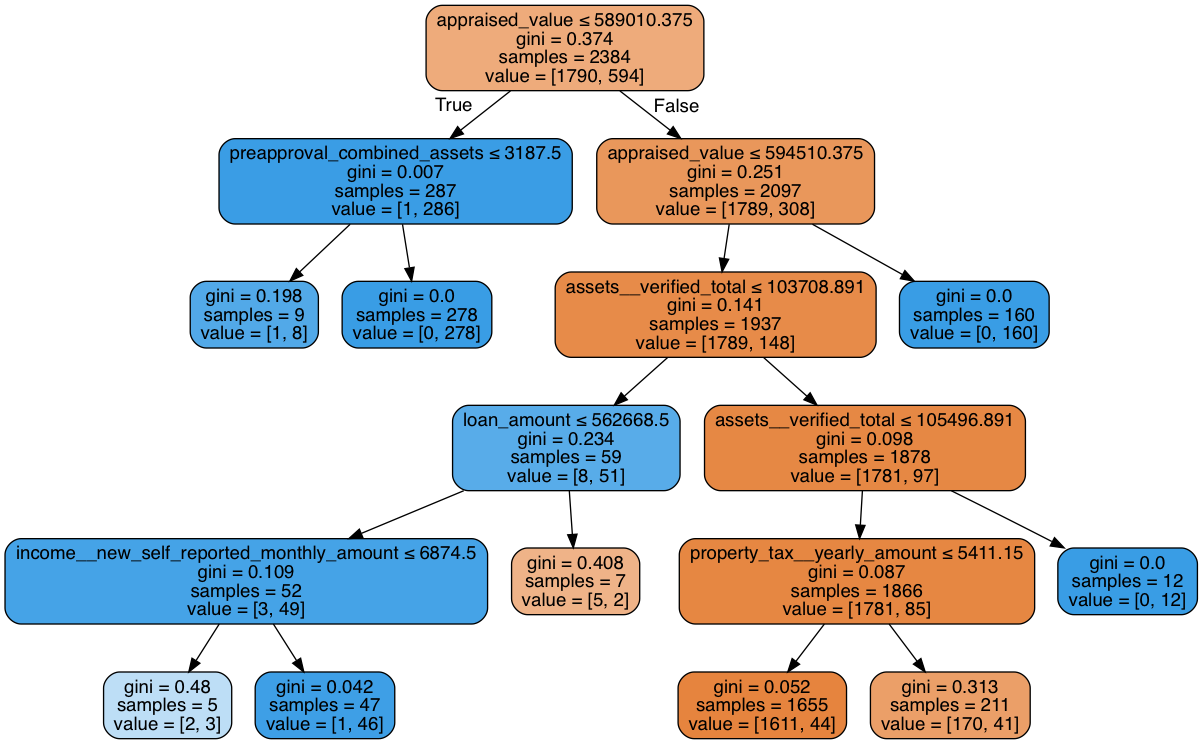

In [54]:
dot_data = StringIO()
export_graphviz(dtree, feature_names=X[include_variables].columns, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<a id='submit'></a>
## Predicting loan submission

A model was able to reliably predict whether an application resulted in a completed loan submission (accuracy: ~97%). Some important features in order of importance (using variables importances from Random Forest model) are:
* The <b>loan to value ratio</b> - users who completed a loan application sought a mean LTV of 0.64 compared to 0.36 <b>(78% higher)</b> for those who didn't complete (LTV values greater than 1 were coerced to 1)
* <b>Preapproval monthly income</b> - users who completed a loan application reported a preapproval monthly income of \$18,192 vs \$11,104 <b>(64% higher)</b> for those didn't complete
* <b>Preapproval combined assets</b> - users who completed a loan application reported combined assets of \$229,076 vs \$175,841 <b>(30% higher)</b> for those didn't complete
* <b>Loan amount</b> - users who completed a loan application were seeking a loan amount of \$344,404 vs \$202,050 <b>(70% higher)</b> for those didn't complete
* <b>Beta credit score proxy</b> - users who completed a loan application had a proxy credit score of 4.37 vs 5.08 <b>(16% lower)</b> for those didn't complete

In general, users who submitted all of their loan documents had a higher income, more assets, lower credit score (beta proxy), and were seeking a higher loan amount with higher LTV.

In [55]:
# Preprocessing

user_app['completed_loan_docs'] = user_app.index.notnull() * 1
user_app['coborrower_contact_created'] = user_app['coborrower_contact_created'].fillna(0)*1
user_app['account_created_month'] = user_app['account_created_month'].apply(lambda x: 'm' + str(x))

app_df = user_app.copy()
app_df = pd.concat([app_df, pd.get_dummies(app_df[['borrower_state_mapped', 'property_type', 'account_created_month']])], axis=1)

app_df.drop(['borrower_state_mapped', 'account_id_mapping', 'property_type', 'account_created_month'], axis=1, inplace=True)
app_df = app_df.fillna(app_df.mean())

In [56]:
X = app_df.drop('completed_loan_docs', axis=1)

rf = RandomForestClassifier(n_estimators=250, min_samples_split=5)
rf.fit(X, app_df['completed_loan_docs'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
columns = X.columns
imp = pd.DataFrame(rf.feature_importances_, index=columns, columns=['feature_importances'])
imp.sort_values(by='feature_importances', ascending=False).head(10)

,feature_importances
ltv,0.266711
preapproval_total_monthly_income,0.184628
preapproval_combined_assets,0.175912
loan_amount,0.165152
beta_credit_score_proxy,0.100681
coborrower_contact_created,0.036805
denied,0.016267
preapproval_id_mapping,0.012812
account_created_month_m4,0.004618
property_type_PrimaryResidence,0.004174


<a id='submit_cv'></a>
#### Cross validation

In [58]:
# Average accuracy

np.mean(cross_val_score(rf, X, app_df['completed_loan_docs'], cv=10))

0.9701793500496672

<a id='submit_preds'></a>
#### Predictors

In [59]:
user_app.groupby('completed_loan_docs')['ltv'].mean()

completed_loan_docs
0    0.359586
1    0.636787
Name: ltv, dtype: float64

In [60]:
user_app.groupby('completed_loan_docs')['preapproval_total_monthly_income'].mean()

completed_loan_docs
0    11104.374670
1    18192.051524
Name: preapproval_total_monthly_income, dtype: float64

In [61]:
user_app.groupby('completed_loan_docs')['preapproval_combined_assets'].mean()

completed_loan_docs
0    175841.017241
1    229076.803087
Name: preapproval_combined_assets, dtype: float64

In [62]:
user_app.groupby('completed_loan_docs')['loan_amount'].mean()

completed_loan_docs
0    202050.889381
1    344404.503859
Name: loan_amount, dtype: float64

In [63]:
user_app.groupby('completed_loan_docs')['beta_credit_score_proxy'].mean()

completed_loan_docs
0    5.081917
1    4.372642
Name: beta_credit_score_proxy, dtype: float64

<a id='submit_tree'></a>
#### Sample Tree

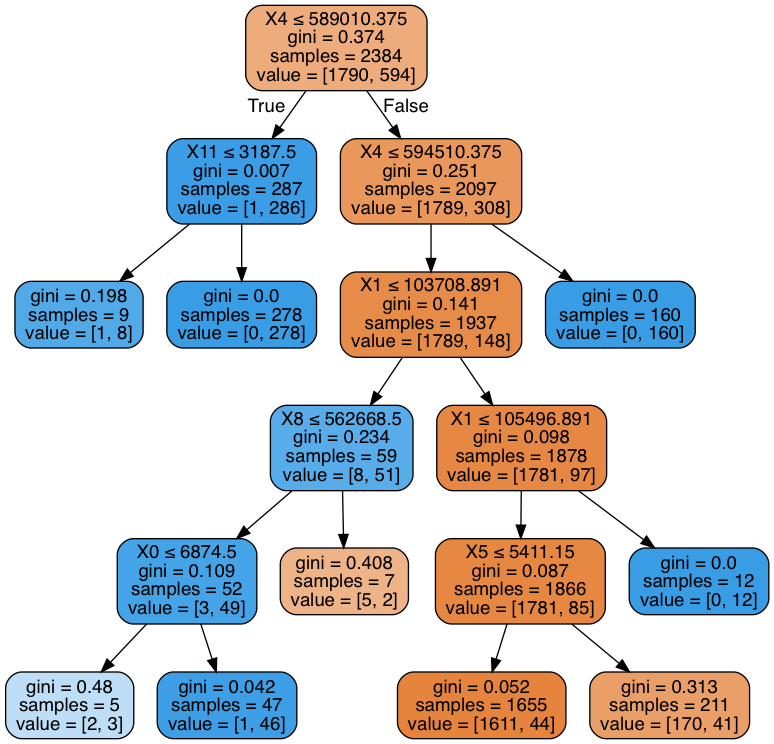

In [64]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())